In [1]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 31.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [2]:
from easyocr import Reader
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
from scipy import ndimage

In [76]:
car = cv2.imread("car10.jpg")
gray = cv2.cvtColor(car,cv2.COLOR_BGR2GRAY)

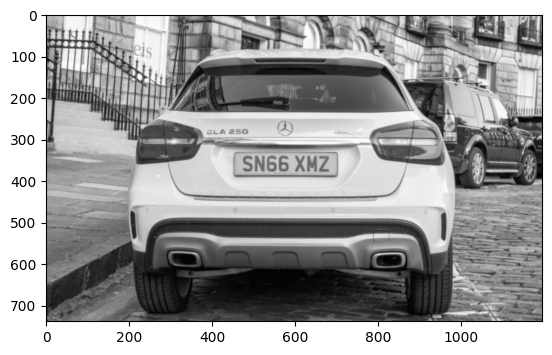

In [78]:
def gaussian_kernel(size, sigma=1):
    # Calculate the size of the kernel (half-size for range calculation)
    size = int(size) // 2
    # Create a meshgrid for the kernel size with values from -size to size
    x, y = np.mgrid[-size:size+1, -size:size+1]
    # Calculate the normalization factor for the Gaussian kernel
    normal = 1 / (2.0 * np.pi * sigma**2)
    # Compute the Gaussian function for each (x, y) in the grid
    g =  np.exp(-((x**2 + y**2) / (2.0 * sigma**2))) * normal
    return g

def apply_kernel(image, kernel):
    # Get the dimensions of the kernel
    m, n = kernel.shape
    # Get the dimensions of the image
    y, x = image.shape
    # Calculate the dimensions of the new image after applying the kernel
    y = y - m + 1
    x = x - n + 1
    # Initialize the new image with zeros
    new_image = np.zeros((y, x))
    # Loop over each pixel in the new image
    for i in range(y):
        for j in range(x):
            # Apply the kernel to the corresponding region of the image
            new_image[i][j] = np.sum(image[i:i+m, j:j+n] * kernel)
    return new_image

# Create a Gaussian kernel with size 5x5 and sigma 1
gk = gaussian_kernel(5, sigma=1)

# Apply the Gaussian kernel to the image to produce a blurred effect
blurred_img = apply_kernel(gray, gk)

# Display the blurred image using matplotlib
plt.imshow(blurred_img, cmap='gray')
plt.show()

<ipython-input-79-8d823cfe8cfb>:8: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Ix = ndimage.filters.convolve(img, Kx)
<ipython-input-79-8d823cfe8cfb>:10: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Iy = ndimage.filters.convolve(img, Ky)


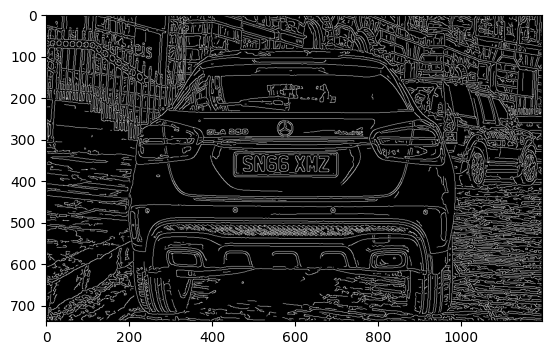

In [79]:
def sobel_filters(img):
    # Define the Sobel kernel for x direction
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    # Define the Sobel kernel for y direction
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    # Convolve the image with the Sobel kernel for x direction
    Ix = ndimage.filters.convolve(img, Kx)
    # Convolve the image with the Sobel kernel for y direction
    Iy = ndimage.filters.convolve(img, Ky)

    # Compute the gradient magnitude
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255  # Normalize to 255
    # Compute the gradient direction
    theta = np.arctan2(Iy, Ix)
    return (G, theta)

def non_max_suppression(img, D):
    # Get the dimensions of the image
    M, N = img.shape
    # Initialize the result image with zeros
    Z = np.zeros((M, N), dtype=np.int32)
    # Convert the gradient direction to degrees
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    # Loop over each pixel in the image (excluding the border pixels)
    for i in range(1, M-1):
        for j in range(1, N-1):
            try:
                q = 255
                r = 255

                # Determine the neighboring pixels to compare based on the gradient direction
                # Angle 0 degrees
                if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                # Angle 45 degrees
                elif (22.5 <= angle[i, j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                # Angle 90 degrees
                elif (67.5 <= angle[i, j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                # Angle 135 degrees
                elif (112.5 <= angle[i, j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                # Keep the pixel value if it is the local maximum; otherwise, set it to zero
                if (img[i, j] >= q) and (img[i, j] >= r):
                    Z[i, j] = img[i, j]
                else:
                    Z[i, j] = 0

            except IndexError as e:
                pass

    return Z

def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    # Compute the high and low thresholds
    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio

    # Get the dimensions of the image
    M, N = img.shape
    # Initialize the result image with zeros
    res = np.zeros((M, N), dtype=np.int32)

    weak = np.int32(25)  # Weak pixel value
    strong = np.int32(255)  # Strong pixel value

    # Identify strong, weak, and zero pixel positions
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    # Assign pixel values based on their threshold category
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return (res, weak, strong)

def hysteresis(img, weak, strong=255):
    # Get the dimensions of the image
    M, N = img.shape
    # Loop over each pixel in the image (excluding the border pixels)
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i, j] == weak):
                try:
                    # Check if any of the neighboring pixels are strong
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong  # Convert weak pixel to strong
                    else:
                        img[i, j] = 0  # Suppress weak pixel
                except IndexError as e:
                    pass
    return img

def canny(img):
    # Smooth the image using Gaussian blur
    img_smoothed = cv2.GaussianBlur(img, (5, 5), 1.4)
    # Compute the gradient magnitude and direction using Sobel filters
    gradientMat, thetaMat = sobel_filters(img_smoothed)
    # Apply non-maximum suppression to thin out the edges
    nonMaxImg = non_max_suppression(gradientMat, thetaMat)
    # Apply double thresholding to identify strong and weak pixels
    thresholdImg, weak, strong = threshold(nonMaxImg)
    # Apply hysteresis to finalize the edge detection
    img_final = hysteresis(thresholdImg, weak, strong)
    return img_final

# Load an image
img = blurred_img

# Apply Canny Edge Detection
edges = canny(img)

# Display the edges
plt.imshow(edges, cmap='gray')
plt.show()

In [80]:
# Convert edges to 8-bit image
edges = cv2.convertScaleAbs(edges)
# Find contours in the edge-detected image
cont, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Sort contours based on area, largest first
cont = sorted(cont, key=cv2.contourArea, reverse=True)

# Loop through contours to find the license plate
for c in cont:
    arc = cv2.arcLength(c, True)  # Calculate contour perimeter
    approx = cv2.approxPolyDP(c, 0.02 * arc, True)  # Approximate the contour
    if len(approx) == 4:  # If the contour has 4 vertices, it might be the license plate
        plate_cnt = approx
        break

# Get bounding rectangle for the license plate
(x, y, w, h) = cv2.boundingRect(plate_cnt)
# Crop the license plate region from the grayscale image
plate = gray[y:y+h, x:x+w]

In [81]:
# Initialize EasyOCR reader
reader = Reader(['en'], gpu=False, verbose=False)
# Use EasyOCR to read text from the license plate
detection = reader.readtext(plate)
print(detection)

[([[18, 4], [242, 4], [242, 58], [18, 58]], 'SN66 XMZ', 0.9374226307548548)]


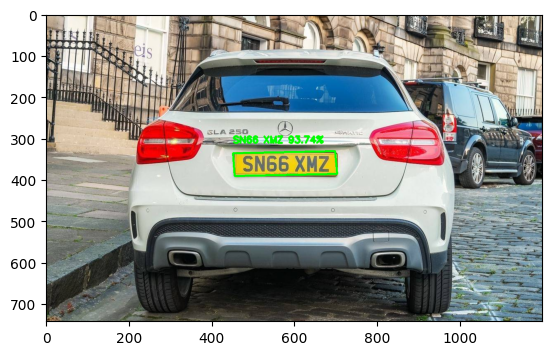

In [82]:
# Check if text was detected
if len(detection) == 0:
    text = 'Impossible to read the text from plate'
    cv2.putText(car, text, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 3)
    plt.imshow(cv2.cvtColor(car, cv2.COLOR_BGR2RGB))
    cv2.waitKey(0)
else:
    # Draw the contour of the license plate on the original image
    cv2.drawContours(car, [plate_cnt], -1, (0, 255, 0), 3)
    text = f'{detection[0][1]} {detection[0][2] * 100:.2f}%'  # Detected text and confidence
    cv2.putText(car, text, (x, y-20), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 3)
    plt.imshow(cv2.cvtColor(car, cv2.COLOR_BGR2RGB))
    cv2.waitKey(0)